In [236]:
import numpy as np
import warnings
import scipy
import pickle
from scipy import linalg
import scipy.io as sio
from pyriemann.utils.mean import mean_covariance
import sklearn.datasets
import sklearn.decomposition
from scipy.spatial import distance

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [253]:

def get_glasser():
    '''
    Navigates through file tree and extracts FCs with optional reconstruction
    '''
    # Yeo ordering
    fname = '../data/100_unrelated.csv'
    yeo = True
    if yeo:
        yeo_order = list(sio.loadmat("../data/yeo_RS7_N374.mat",
                                     squeeze_me=True,
                                     struct_as_record=False)['yeoOrder'] - 1)
    # Load subject ID and task names
    subjectids = np.loadtxt(fname, dtype=np.int)
    nSubj = len(subjectids)
    tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
             'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
             'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
             'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
             'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
             'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']
    M = {}
    # Walk through file tree and extract FCs
    for task in tasks:
        masterFC_dir = '../data/results_SIFT2'
        restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
        task_matrices = []
        for subject in subjectids:
            filename = masterFC_dir + '/' + \
                str(subject) + '/' + restingstatename
            mat = sio.loadmat(filename, squeeze_me=True,
                              struct_as_record=False)
            A_orig = mat['FC']
            if yeo:
                A_orig = A_orig[np.ix_(yeo_order, yeo_order)]
            np.fill_diagonal(A_orig, 1)
            task_matrices.append(A_orig)
        M[task] = np.array(task_matrices)
    test = np.concatenate((M['rfMRI_REST1_LR'], M['tfMRI_EMOTION_LR'],
                           M['tfMRI_GAMBLING_LR'], M['tfMRI_LANGUAGE_LR'],
                           M['tfMRI_MOTOR_LR'], M['tfMRI_RELATIONAL_LR'],
                           M['tfMRI_SOCIAL_LR'], M['tfMRI_WM_LR']))
    retest = np.concatenate((M['rfMRI_REST1_RL'], M['tfMRI_EMOTION_RL'],
                             M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_RL'],
                             M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_RL'],
                             M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_RL']))
    del M
    all_FC = np.concatenate((test, retest))
    del test, retest
    return all_FC, nSubj


def get_schaefer(parc, ref='none'):
    if ref.lower() == 'none':
        with open(f'../data/schaefer/schaefer{parc}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    else:
        with open(f'../data/tangent_fcs/schaefer{parc}_{ref}.pickle', 'rb') as f:
            all_FC = pickle.load(f)
    nSubj = int(all_FC.shape[0]/16)
    return all_FC, nSubj


def q1invm(q1, eig_thresh=0):
    q1 += np.eye(q1.shape[0])
    U, S, V = scipy.linalg.svd(q1)
    S = np.diag(S ** (-1 / 2))
    Q1_inv_sqrt = U @ S @ V
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U @ S @ V
    return Q


def tangential(all_FC, ref):
    # Regularization for riemann
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    Cg = mean_covariance(all_FC, metric=ref)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.empty(Q.shape)
    for idx, fc in enumerate(Q):
        if idx % 100 == 0:
            print(f'{idx}/{Q.shape[0]}')
        tangent_FC[idx] = linalg.logm(fc)
    return tangent_FC


def pca_recon(FC, pctComp=None):
    '''
    Reconstructs FC based on number of principle components
    '''
    if pctComp is None:
        return FC
    FC = np.reshape(FC, (FC.shape[0], -1))
    nComp = int(FC.shape[0] * pctComp)
    mu = np.mean(FC, axis=0)
    pca_rest = sklearn.decomposition.PCA()
    pca_rest.fit(FC)
    SCORES = pca_rest.transform(FC)[:, :nComp]
    COEFFS = pca_rest.components_[:nComp, :]
    FC_recon = np.dot(SCORES, COEFFS)
    del SCORES, COEFFS
    FC_recon += mu
    FC_recon = np.reshape(FC_recon, (FC.shape[0], 374, 374))
    return FC_recon


   

In [238]:
# Navigate tree and get raw correlation FC matrices
print("Importing all correlation matrices...", end=" ")
all_FC, nSubj = get_schaefer(100)
print("All FCs successfully loaded!\n")

Importing all correlation matrices... All FCs successfully loaded!



In [203]:
# Navigate tree and get raw correlation FC matrices
print("Importing all correlation matrices...", end=" ")
all_FC, nSubj = get_glasser()
print("All FCs successfully loaded!\n")

Importing all correlation matrices... All FCs successfully loaded!



In [250]:
warnings.filterwarnings("ignore")
for ref in ['euclid', 'riemann', 'kullback_sym', 'harmonic', 'logeuclid']:
    print(f'{parc}:{ref}')
    # Navigate tree and get raw correlation FC matrices
    all_FC, nSubj = get_glasser()
    print("All FCs successfully loaded!\n")
    tangent_FCs = tangential(all_FC, ref)
    with open(f'../data/tangent_fcs/glasser_{ref}.pickle', 'wb') as f:
        pickle.dump(tangent_FCs, f, protocol=4)

100:euclid


KeyboardInterrupt: 

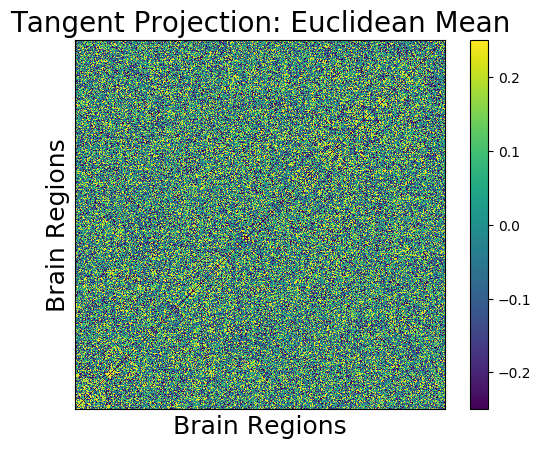

In [195]:
plt.imshow(tangent_FCs[0],origin='lower')
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.colorbar()
if ref == 'euclid':
    plt.clim(-1,1)
plt.xticks([], [])
plt.yticks([],[])
plt.title(f'Tangent Projection: Euclidean Mean', fontdict = {'fontsize' : 20})
plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.clim(-0.25, 0.25)
plt.savefig(f'../results/tangent_fc_euclid.eps', bbox_inches='tight')
plt.show()

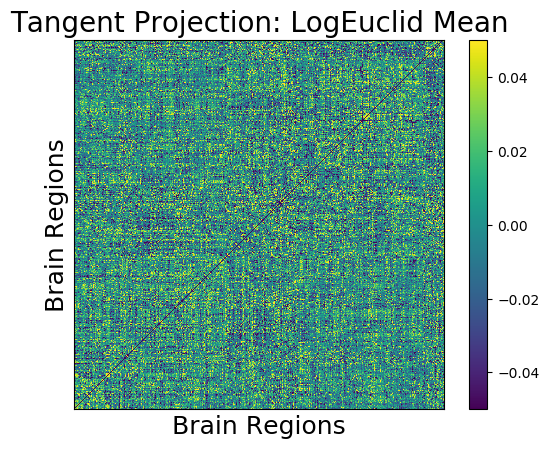

In [202]:
plt.imshow(tangent_FCs[0],origin='lower')
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.colorbar()
if ref == 'euclid':
    plt.clim(-1,1)
plt.xticks([], [])
plt.yticks([],[])
plt.title(f'Tangent Projection: LogEuclid Mean', fontdict = {'fontsize' : 20})
plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.clim(-0.05, 0.05)
plt.savefig(f'../results/tangent_fc_logeuclid.eps', bbox_inches='tight')
plt.show()

In [251]:
all_FC, nSubj = get_glasser()
with open(f'../data/glasser.pickle', 'wb') as f:
    pickle.dump(all_FC, f, protocol=4)

### Plot reference matrices

Importing all correlation matrices... All FCs successfully loaded!

kullback_sym
Adding regularization!


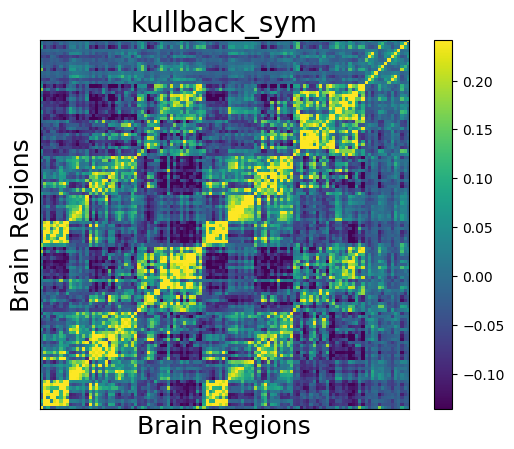

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
for ref in ['kullback_sym']:
    print("Importing all correlation matrices...", end=" ")
    all_FC, nSubj = get_schaefer(100)
    print("All FCs successfully loaded!\n")
    print(ref)
    if ref in ['riemann', 'kullback_sym', 'logeuclid']:
        print("Adding regularization!")
        eye_mat = np.eye(all_FC.shape[1])
        scaling_mat = np.repeat(eye_mat[None, ...], all_FC.shape[0], axis=0)
        all_FC += scaling_mat
    kullback_Cg = mean_covariance(all_FC, metric=ref)
    plt.style.use('default')
    sampleFC = kullback_Cg
    plt.imshow(sampleFC,origin='lower')
    plt.ylabel('Brain Regions')
    plt.xlabel('Brain Regions')
    plt.colorbar()
    plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
#     if ref == 'euclid':
#         plt.clim(-1,1)
        
    plt.xticks([], [])
    plt.yticks([],[])
    plt.title(f'{ref}', fontdict = {'fontsize' : 20})
    plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
    plt.savefig(f'../results/tangent_references/reference_{ref}.eps', bbox_inches='tight')
    plt.show()

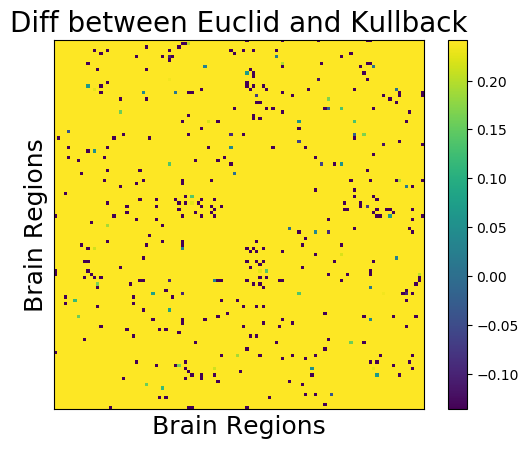

In [261]:
diff_mat = euclid_Cg / kullback_Cg
plt.style.use('default')
sampleFC = diff_mat
plt.imshow(sampleFC,origin='lower')
plt.ylabel('Brain Regions')
plt.xlabel('Brain Regions')
plt.colorbar()
plt.clim(np.percentile(Cg, 5), np.percentile(Cg, 95))
#     if ref == 'euclid':
#         plt.clim(-1,1)

plt.xticks([], [])
plt.yticks([],[])
plt.title(f'Diff between Euclid and Kullback', fontdict = {'fontsize' : 20})
plt.ylabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.xlabel('Brain Regions',fontdict = {'fontsize' : 18})
plt.show()

In [239]:
classifier = 'task'
if classifier == 'task':
    labels = np.tile(np.repeat(np.arange(0, 8), nSubj), 2)
    indices = np.random.permutation(nSubj)
    train_idx = indices[:int(0.80 * nSubj)]
    test_idx = indices[int(0.8 * nSubj):]
    train_idx_all, test_idx_all = np.empty(0, dtype=int), np.empty(0, dtype=int)
    for fc in np.arange(0, 16):
        train_idx_all = np.concatenate((train_idx_all, (fc * nSubj) + train_idx)).astype(int)
        test_idx_all = np.concatenate((test_idx_all, (fc * nSubj) + test_idx)).astype(int)
    train_idx = train_idx_all
    test_idx = test_idx_all
elif classifier == 'subject':
    labels = np.tile(np.tile(np.arange(0,nSubj),8),2)
    indices = np.random.permutation(all_FC.shape[0])
    train_idx = indices[:int(0.80 * all_FC.shape[0])]
    test_idx = indices[int(0.80 * all_FC.shape[0]):]
else:
    pass

train_labels = labels[train_idx]
test_labels = labels[test_idx]

In [246]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

accuracies = {}
for ref in ['none', 'euclid', 'harmonic', 'logeuclid', 'kullback_sym', 'riemann']:
    all_FC, nSubj = get_schaefer(100, ref)
    train_FCs = np.zeros((len(train_idx),6441), dtype=np.float32)
    for idx, mat in enumerate(all_FC[train_idx]):
        train_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=1)]
    test_FCs = np.zeros((len(test_idx),6441), dtype=np.float32)
    for idx, mat in enumerate(all_FC[test_idx]):
        test_FCs[idx] = mat[np.triu_indices(mat.shape[0], k=1)]
    for distance_method in ['correlation', 'cosine', 'euclidean']:
        print(f'Testing {ref} reference with {distance_method} distance...')
        neigh = KNeighborsClassifier(n_neighbors=5, metric=distance_method)
        neigh.fit(train_FCs, train_labels)
        predicted = neigh.predict(test_FCs)
        acc = accuracy_score(test_labels, predicted)
        print(acc)
        accuracies[ref+"_"+distance_method] = acc

Testing none reference with correlation distance...
0.8073529411764706
Testing none reference with cosine distance...
0.8066176470588236
Testing none reference with euclidean distance...
0.6345588235294117
Testing euclid reference with correlation distance...
0.44191176470588234
Testing euclid reference with cosine distance...
0.44485294117647056
Testing euclid reference with euclidean distance...
0.25
Testing harmonic reference with correlation distance...
0.21911764705882353
Testing harmonic reference with cosine distance...
0.22941176470588234
Testing harmonic reference with euclidean distance...
0.25
Testing logeuclid reference with correlation distance...
0.8801470588235294
Testing logeuclid reference with cosine distance...
0.875
Testing logeuclid reference with euclidean distance...
0.5595588235294118
Testing kullback_sym reference with correlation distance...
0.8779411764705882
Testing kullback_sym reference with cosine distance...
0.8735294117647059
Testing kullback_sym refere

In [249]:
import csv

a_file = open(f"../results/tasks/distances_tangent.csv", "w")

writer = csv.writer(a_file)
for key, value in accuracies.items():
    writer.writerow([key, value])
    
a_file.close()

### KNN Approach